#Gambaran Umum, Latar Belakang, Rumusan Masalah

##Gambaran Umum

Perusahaan Bike Sharing System (BSS) merupakan penyedia layanan penyewaan sepeda berbasis sistem otomatis di kawasan perkotaan. Pengguna dapat menyewa sepeda dari satu stasiun dan mengembalikannya ke stasiun lain secara fleksibel melalui aplikasi digital.
BSS berperan dalam mendukung mobilitas berkelanjutan (sustainable mobility), mengurangi kemacetan, polusi udara, dan konsumsi bahan bakar fosil. Sistem ini umumnya digunakan oleh masyarakat perkotaan, wisatawan, maupun pekerja harian yang melakukan perjalanan jarak pendek.

Dalam operasionalnya, perusahaan menghadapi tantangan besar dalam perencanaan jumlah sepeda yang optimal di setiap stasiun. Jumlah permintaan yang terlalu tinggi dapat menyebabkan kekurangan sepeda, sedangkan permintaan rendah dapat menimbulkan inefisiensi biaya perawatan dan distribusi. Oleh karena itu, diperlukan model prediksi jumlah penyewaan sepeda (rental demand forecasting) yang akurat untuk mendukung keputusan operasional harian, mingguan, maupun bulanan.

##Latar Belakang

Perkembangan teknologi Internet of Things (IoT) dan sistem sensor telah memungkinkan pencatatan data operasional sepeda secara real time. Data tersebut mencakup variabel seperti suhu, kelembapan, kecepatan angin, kondisi cuaca, hari kerja/libur, serta jumlah pengguna casual dan registered.
Namun, data yang kompleks dan bersifat musiman ini membuat prediksi manual menjadi sulit dan sering tidak akurat. Dalam konteks bisnis, prediksi permintaan sepeda menjadi hal krusial untuk:
- Mengatur stok sepeda agar sesuai dengan kebutuhan pengguna.
- Mengoptimalkan penjadwalan maintenance dan distribusi sepeda antar stasiun.
- Mendukung strategi pricing berdasarkan tren permintaan.
- Mengurangi biaya operasional akibat ketidakseimbangan pasokan dan permintaan.

Oleh karena itu, proyek ini dikembangkan untuk membangun sistem prediksi jumlah penyewaan sepeda menggunakan pendekatan Machine Learning dan Time Series Forecasting (SARIMA), serta pendekatan Hybrid Model untuk menggabungkan keunggulan keduanya.

##Rumusan Masalah

Berdasarkan latar belakang di atas, maka rumusan masalah pada proyek ini adalah:

- Bagaimana memprediksi jumlah penyewaan sepeda (bike rental demand) secara akurat berdasarkan variabel cuaca dan waktu?

- Bagaimana performa model Machine Learning (Gradient Boosting/Random Forest) dibandingkan dengan model Time Series (SARIMA)?

- Apakah pendekatan Hybrid (gabungan ML dan SARIMA) dapat meningkatkan akurasi prediksi dibandingkan model tunggal?

- Bagaimana hasil prediksi tersebut dapat dimanfaatkan untuk mendukung efisiensi operasional perusahaan Bike Sharing?

##Tujuan Capstone

| No | Tujuan                                                              | Penjelasan                                                                                                                   |
| -- | ------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------- |
| 1  | Mengumpulkan dan membersihkan data historis penyewaan sepeda        | Melakukan preprocessing pada dataset Bike Sharing agar siap untuk analisis dan modeling.                                     |
| 2  | Menganalisis faktor-faktor yang memengaruhi jumlah penyewaan sepeda | Melihat pengaruh variabel cuaca, hari, dan waktu terhadap permintaan sepeda.                                                 |
| 3  | Membangun dan membandingkan model prediksi                          | Menggunakan model Machine Learning (Gradient Boosting), Time Series (SARIMA), dan Hybrid Model untuk memprediksi permintaan. |
| 4  | Mengevaluasi performa model                                         | Mengukur kinerja model menggunakan metrik RMSE, MAE, dan R² pada data harian, mingguan, dan bulanan.                         |
| 5  | Menyediakan insight bisnis                                          | Memberikan rekomendasi berbasis data untuk pengelolaan sepeda, distribusi, dan strategi operasional.                         |


| Jenis Goal         | Deskripsi                                                                                                                                                                                 |
| ------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Business Goal**  | Menyediakan alat bantu prediksi permintaan sepeda agar perusahaan dapat mengatur ketersediaan unit dengan efisien, mengurangi biaya operasional, dan meningkatkan kepuasan pelanggan.     |
| **Technical Goal** | Membangun model prediksi berbasis data historis menggunakan Machine Learning dan SARIMA, serta mengembangkan model hybrid dengan performa optimal berdasarkan evaluasi RMSE, MAE, dan R². |


#Library

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import joblib
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Data Load & Check

In [ ]:
df = pd.read_csv('/content/data_bike_sharing.csv')
df

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt
0,2011-12-09,0.62,1,0,4,0.3485,0.36,16,24,226,250
1,2012-06-17,0.64,1,0,2,0.5152,0.54,4,2,16,18
2,2011-06-15,0.53,1,0,2,0.6212,0.62,23,17,90,107
3,2012-03-31,0.87,2,0,2,0.3485,0.36,8,19,126,145
4,2012-07-31,0.55,1,0,3,0.6970,0.76,18,99,758,857
...,...,...,...,...,...,...,...,...,...,...,...
12160,2012-01-25,0.75,1,0,1,0.2273,0.24,7,14,243,257
12161,2012-07-06,0.62,1,0,3,0.7424,0.78,0,39,63,102
12162,2012-02-20,0.60,2,1,1,0.2121,0.24,5,0,6,6
12163,2012-03-31,0.77,2,0,2,0.4242,0.42,2,14,55,69


Dataset ini mencatat jumlah penyewaan sepeda (bike rentals) di Washington D.C. berdasarkan kondisi cuaca dan waktu.
Tiap baris mewakili satu pengamatan (bisa per jam atau per hari tergantung subset datanya).

| Kolom          | Tipe      | Deskripsi                                                                                                                                 |
| -------------- | --------- | ----------------------------------------------------------------------------------------------------------------------------------------- |
| **dteday**     | datetime  | Tanggal observasi dilakukan (format YYYY-MM-DD).                                                                                          |
| **hum**        | float     | Humidity (kelembapan relatif) dalam skala 0–1. Contoh: 0.62 = 62%.                                                                        |
| **weathersit** | int       | Kategori kondisi cuaca: <br>1 = Cerah/Berawan sedikit ☀️ <br>2 = Berawan/berkabut ⛅ <br>3 = Hujan ringan 🌧️ <br>4 = Hujan deras/Salju ⛈️ |
| **holiday**    | int (0/1) | 1 jika hari tersebut libur nasional, 0 jika bukan.                                                                                        |
| **season**     | int       | Musim pada hari tersebut: <br>1 = Musim semi 🌸 <br>2 = Musim panas ☀️ <br>3 = Musim gugur 🍂 <br>4 = Musim dingin ❄️                     |
| **atemp**      | float     | “Feeling temperature” alias temperatur yang dirasakan, dinormalisasi (0–1).                                                               |
| **temp**       | float     | Temperatur aktual, juga dinormalisasi (0–1).                                                                                              |
| **hr**         | int       | Jam pengamatan (0–23).                                                                                                                    |
| **casual**     | int       | Jumlah penyewa sepeda yang **tidak terdaftar/member** (pengguna umum).                                                                    |
| **registered** | int       | Jumlah penyewa sepeda yang **terdaftar/member**.                                                                                          |
| **cnt**        | int       | Total jumlah penyewaan sepeda (`casual + registered`). Ini yang biasanya dijadikan **target** untuk prediksi.                             |


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      12165 non-null  object 
 1   hum         12165 non-null  float64
 2   weathersit  12165 non-null  int64  
 3   holiday     12165 non-null  int64  
 4   season      12165 non-null  int64  
 5   atemp       12165 non-null  float64
 6   temp        12165 non-null  float64
 7   hr          12165 non-null  int64  
 8   casual      12165 non-null  int64  
 9   registered  12165 non-null  int64  
 10  cnt         12165 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 1.0+ MB


Menampilkan informasi tipe data dan jumlah missing value pada setiap kolom. Data ini memperlihatkan bahwa tidak ada missing values sama sekali. Semua 11 kolom sama-sama memiliki 12165 baris

In [ ]:
df.isnull().sum()

,0
dteday,0
hum,0
weathersit,0
holiday,0
season,0
atemp,0
temp,0
hr,0
casual,0
registered,0


Untuk lebih jelas dalam menampilkan jumlah nilai kosong (missing value) di setiap kolom.

In [ ]:
df.duplicated().sum()

np.int64(0)

Menghitung jumlah baris duplikat pada dataset. Dalam data ini tidak terlihat adanya data duplikat

#Data Cleaning

In [ ]:
df['dteday'] = pd.to_datetime(df['dteday'])
df['dt'] = pd.to_datetime(df['dteday'].dt.strftime('%Y-%m-%d') + ' ' + df['hr'].astype(str) + ':00:00')
df = df.sort_values('dt').reset_index(drop=True).set_index('dt')
df['cnt'] = df['casual'] + df['registered']

- Mengubah kolom tanggal ke format datetime.
- Membuat kolom waktu lengkap (dt) dari tanggal dan jam.
- Menjadikan kolom dt sebagai index dan mengurutkan data.
- Membuat kolom jumlah rental total (cnt) dari casual dan registered.

In [ ]:
df['cnt']

,cnt
dt,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1
...,...
2012-12-31 14:00:00,247
2012-12-31 16:00:00,214
2012-12-31 17:00:00,164


Menampilkan kolom jumlah rental sepeda per jam sebagai hasil cleaning dan penambahan fitur.

#Feature Engineering (hourly)

In [ ]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['month'] = df.index.month
df['is_rush'] = df['hour'].isin([7,8,9,16,17,18,19]).astype(int)

Menambahkan fitur waktu seperti jam, hari dalam minggu, apakah weekend, bulan, dan apakah jam sibuk (rush hour) untuk memperkaya data input ke model.

In [ ]:
df['lag_1'] = df['cnt'].shift(1)
df['lag_24'] = df['cnt'].shift(24)
df['roll_mean_3'] = df['cnt'].shift(1).rolling(window=3, min_periods=1).mean()
df['roll_mean_24'] = df['cnt'].shift(1).rolling(window=24, min_periods=1).mean()

- Menambahkan fitur lag dan rata-rata bergerak untuk menangkap pola historis peminjaman sepeda.
- lag_k: nilai variabel pada k periode sebelumnya.
- lag_1 → nilai 1 langkah/periode sebelumnya (misal, jam/tanggal kemarin).
- lag_24 → nilai 24 langkah/periode sebelumnya (misal, kalau data hourly → nilai 24 jam yang lalu; kalau daily → nilai 24 hari yang lalu).

- roll_k: nilai agregat (rolling statistic) dari jendela (window) sepanjang k periode terakhir. Bisa berupa rata-rata, median, std, dsb.
- roll_1 → rata-rata dari 1 periode terakhir (praktis sama dengan nilai sekarang).
- roll_24 → rata-rata dari 24 periode terakhir (misal, rata-rata 24 jam terakhir kalau data hourly).
- Lag dan roll penting dalam analisis Time Series, karena lag dan rolling membantu model menangkap pola ketergantungan waktu (autokorelasi) dan tren jangka pendek/panjang dalam data time series, sehingga prediksi menjadi lebih akurat dan kontekstual

In [ ]:
df_ml = df.copy()
df_ml = df_ml.dropna(subset=['lag_1','lag_24','roll_mean_3','roll_mean_24'])

Menghapus baris yang memiliki missing value pada fitur lag dan rolling mean agar data siap digunakan untuk training model machine learning.

In [ ]:
df_ml

,dteday,hum,weathersit,holiday,season,atemp,temp,hr,casual,registered,cnt,hour,dayofweek,is_weekend,month,is_rush,lag_1,lag_24,roll_mean_3,roll_mean_24
dt,,,,,,,,,,,,,,,,,,,,
2011-01-02 13:00:00,2011-01-02,0.66,2,0,1,0.3485,0.36,13,11,64,75,13,6,1,1,0,70.0,16.0,30.333333,31.250000
2011-01-02 16:00:00,2011-01-02,0.71,3,0,1,0.3333,0.34,16,9,67,76,16,6,1,1,1,75.0,40.0,55.000000,33.708333
2011-01-02 17:00:00,2011-01-02,0.57,1,0,1,0.3333,0.34,17,7,58,65,17,6,1,1,1,76.0,32.0,73.666667,35.208333
2011-01-02 18:00:00,2011-01-02,0.46,2,0,1,0.3333,0.36,18,10,43,53,18,6,1,1,1,65.0,13.0,72.000000,36.583333
2011-01-02 20:00:00,2011-01-02,0.39,1,0,1,0.2727,0.30,20,5,17,22,20,6,1,1,0,53.0,1.0,64.666667,38.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 14:00:00,2012-12-31,0.45,2,0,1,0.2727,0.28,14,62,185,247,14,0,0,12,0,203.0,60.0,160.000000,85.958333
2012-12-31 16:00:00,2012-12-31,0.48,2,0,1,0.2576,0.26,16,30,184,214,16,0,0,12,1,247.0,54.0,190.000000,93.750000
2012-12-31 17:00:00,2012-12-31,0.48,2,0,1,0.2879,0.26,17,14,150,164,17,0,0,12,1,214.0,32.0,221.333333,100.416667


Hasil data setelah dilakukan data cleaning + feature engineering

#Train Test (hourly)

In [ ]:
feature_cols = ['hour','dayofweek','is_weekend','month','is_rush',
                'season','holiday','weathersit','temp','atemp','hum',
                'lag_1','lag_24','roll_mean_3','roll_mean_24']
X = df_ml[feature_cols].copy()
y = np.log1p(df_ml['cnt'])

Menentukan fitur yang digunakan untuk model dan target variabel (jumlah rental, di-log transform untuk stabilitas).

In [ ]:
n = len(X)
test_size = max(1, int(0.2 * n))
train_end = n - test_size
X_train, X_test = X.iloc[:train_end], X.iloc[train_end:]
y_train, y_test = y.iloc[:train_end], y.iloc[train_end:]

Membagi data menjadi data training dan testing dengan rasio 80:20.

#Preprocessing Pipeline

In [ ]:
numeric_features = ['temp','atemp','hum','lag_1','lag_24','roll_mean_3','roll_mean_24']
categorical_features = ['season','holiday','weathersit','hour','dayofweek','is_weekend','month','is_rush']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['temp', 'atemp', 'hum', 'lag_1', 'lag_24',
                                  'roll_mean_3', 'roll_mean_24']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['season', 'holiday', 'weathersit', 'hour',
                                  'dayofweek', 'is_weekend', 'month',
                                  'is_rush'])])

Membuat pipeline preprocessing untuk fitur numerik (imputasi dan scaling) dan fitur kategorikal (one-hot encoding).
- numeric_features → berisi variabel bertipe numerik, seperti suhu, kelembapan, dan hasil lag/rolling.
- categorical_features → berisi variabel bertipe kategorikal, seperti musim, kondisi cuaca, hari dalam seminggu, dll.
- SimpleImputer(strategy='mean') → mengisi nilai missing dengan rata-rata kolom (agar tidak error saat training).
- StandardScaler() → menstandarkan skala fitur agar memiliki mean = 0 dan standar deviasi = 1.
- OneHotEncoder() → mengubah data kategorikal menjadi bentuk numerik biner (dummy variable).
Contoh: season dengan 4 kategori → jadi 4 kolom baru (season_1, season_2, season_3, season_4).
- handle_unknown='ignore' → agar tidak error jika ada kategori baru saat prediksi (yang tidak muncul di data training).
- ColumnTransformer memungkinkan kita memproses kolom numerik dan kategorikal secara paralel dan otomatis.
- Output akhirnya berupa array numerik siap pakai untuk model machine learning.

#Training + Hyperparameter Tuning (hourly)

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=1))
])
param_rf = {
    'model__n_estimators': [50,100],
    'model__max_depth': [5,10,None],
    'model__max_features': ['sqrt','log2']
}

pipe_gb = Pipeline([
    ('pre', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])
param_gb = {
    'model__n_estimators': [50,100],
    'model__learning_rate': [0.01,0.1],
    'model__max_depth': [3,5]
}

best_models = {}
for name, pipe, params in [('rf', pipe_rf, param_rf), ('gb', pipe_gb, param_gb)]:
    rsearch = RandomizedSearchCV(
        pipe, params, n_iter=4, cv=tscv,
        scoring='neg_root_mean_squared_error', random_state=42, n_jobs=1
    )
    rsearch.fit(X_train, y_train)
    best_models[name] = rsearch.best_estimator_
    print(f"{name} best params:", rsearch.best_params_)

rf best params: {'model__n_estimators': 100, 'model__max_features': 'sqrt', 'model__max_depth': None}
gb best params: {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}


Melakukan training dan tuning hyperparameter untuk Random Forest dan Gradient Boosting menggunakan cross-validation time series.
- TimeSeriesSplit digunakan karena data bersifat time series (berurutan berdasarkan waktu).
- Pipeline terdiri dari dua tahap:
- - pre → preprocessing otomatis (imputasi, scaling, encoding).
- -  model → algoritma Random Forest & Gradient Boosting.
- n_estimators: jumlah pohon (semakin besar, semakin stabil tapi lebih lama).
- max_depth: batas kedalaman pohon.
- max_features: jumlah fitur yang dipertimbangkan tiap split.
- RandomizedSearchCV → memilih kombinasi hyperparameter secara acak (lebih efisien daripada Grid Search).
- n_iter=4 → mencoba 4 kombinasi acak dari grid parameter.
- cv=tscv → pakai TimeSeriesSplit untuk cross-validation.
- scoring='neg_root_mean_squared_error' → metrik yang digunakan adalah RMSE (semakin kecil semakin baik).

#Evaluasi Model

In [ ]:
def eval_model(model, X_test, y_test_log):
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)
    return {
        'rmse': math.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'y_true': y_true, 'y_pred': y_pred,
        'index': X_test.index
    }

evals = {name: eval_model(m, X_test, y_test) for name, m in best_models.items()}
for name, res in evals.items():
    print(f"{name} → RMSE: {res['rmse']:.2f}, MAE: {res['mae']:.2f}, R²: {res['r2']:.3f}")

best_name = max(evals.keys(), key=lambda k: evals[k]['r2'])
best_model_hourly = best_models[best_name]
print("Selected hourly model:", best_name)

rf → RMSE: 105.16, MAE: 67.76, R²: 0.772
gb → RMSE: 86.98, MAE: 55.01, R²: 0.844
Selected hourly model: gb


Mengevaluasi performa model pada data test dan memilih model terbaik berdasarkan skor R².
| Model                      | RMSE   | MAE   | R²    | Keterangan                                                                                           |
| :------------------------- | :----- | :---- | :---- | :--------------------------------------------------------------------------------------------------- |
| **Random Forest (RF)**     | 105.16 | 67.76 | 0.772 | Performa baik, namun masih ada error cukup besar.                                                    |
| **Gradient Boosting (GB)** | 86.98  | 55.01 | 0.844 | Performa lebih baik dibanding RF, error lebih kecil, dan mampu menjelaskan variasi data lebih besar. |


| **Model**                  | **RMSE**   | **MAE**   | **R²**    | **Interpretasi terhadap Data Bike Sharing**                                                                                                                                                                      |
| :------------------------- | :--------- | :-------- | :-------- | :--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Random Forest (RF)**     | **105.16** | **67.76** | **0.772** | Model mampu menjelaskan sekitar **77,2% variasi jumlah penyewaan sepeda (cnt)** berdasarkan fitur cuaca, suhu, jam, musim, dsb. Namun rata-rata kesalahan prediksi masih sekitar **68–105 unit sepeda per jam**. |
| **Gradient Boosting (GB)** | **86.98**  | **55.01** | **0.844** | Model menjelaskan sekitar **84,4% variasi jumlah penyewaan sepeda (cnt)**. Kesalahan rata-rata prediksi lebih kecil, sekitar **55–87 sepeda per jam**, menunjukkan akurasi yang lebih tinggi.                    |


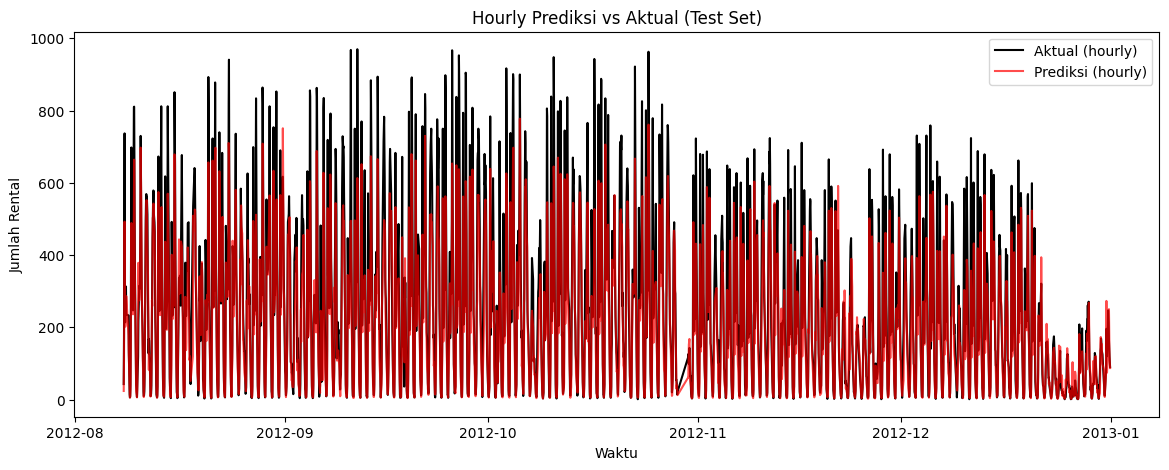

In [ ]:
res = evals[best_name]
plt.figure(figsize=(14,5))
plt.plot(res['index'], res['y_true'], label="Aktual (hourly)", color="black")
plt.plot(res['index'], res['y_pred'], label="Prediksi (hourly)", color="red", alpha=0.7)
plt.title("Hourly Prediksi vs Aktual (Test Set)")
plt.xlabel("Waktu")
plt.ylabel("Jumlah Rental")
plt.legend()
plt.show()

Menampilkan plot perbandingan antara data aktual dan prediksi model pada data test.

| **Aspek**                                  | **Penjelasan**                                                                                                                                                                                                                                                          |
| :----------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Sumbu X (horizontal)**                   | Menunjukkan **rentang waktu dari Agustus 2012 hingga Januari 2013**, dengan satuan jam. Ini merupakan periode data uji (*test set*) yang digunakan untuk mengevaluasi performa model.                                                                                   |
| **Sumbu Y (vertikal)**                     | Menunjukkan **jumlah penyewaan sepeda (rental count)** dalam satuan unit per jam.                                                                                                                                                                                       |
| **Garis hitam (Aktual)**                   | Menunjukkan **jumlah penyewaan sepeda yang sebenarnya terjadi** berdasarkan data historis.                                                                                                                                                                              |
| **Garis merah (Prediksi)**                 | Menunjukkan **hasil prediksi model Gradient Boosting (GB)** terhadap jumlah penyewaan sepeda setiap jam.                                                                                                                                                                |
| **Pola umum**                              | Kedua garis menunjukkan pola **musiman dan harian yang sangat mirip**, di mana jumlah penyewaan meningkat pada jam-jam sibuk (pagi dan sore hari) serta menurun pada malam hari. Ini menunjukkan model mampu **menangkap pola periodik permintaan sepeda** dengan baik. |
| **Perbedaan antara garis merah dan hitam** | Terjadi beberapa deviasi — terutama pada **puncak permintaan tinggi (peak hours)** — di mana model cenderung **sedikit meremehkan nilai aktual (underestimate)**. Namun, di luar jam sibuk, prediksi model cukup konsisten dengan nilai aktual.                         |
| **Konsistensi prediksi**                   | Meskipun terdapat fluktuasi harian yang besar, garis merah tetap **mengikuti tren utama** dari data aktual, yang berarti model cukup adaptif terhadap variasi waktu dan cuaca.                                                                                          |


#Save Model Hourly

In [ ]:
joblib.dump(best_model_hourly, "best_hourly_model.pkl")

['best_hourly_model.pkl']

Menyimpan model terbaik ke file agar bisa digunakan untuk deployment atau aplikasi Streamlit.

#Load Model

In [ ]:
model_path =  '/content/best_hourly_model.pkl'
loaded = joblib.load(model_path)
print(f"Successfully loaded: \n{loaded}")

Successfully loaded: 
Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'lag_1', 'lag_24',
                                                   'roll_mean_3',
                                                   'roll_mean_24']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                             

Menguji proses load model yang sudah disimpan untuk memastikan model bisa digunakan kembali.

#Time Series Forecasting

In [ ]:
def eval_model_hourly(model, X_test, y_test_log):
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)
    return {
        'rmse': math.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'y_true': pd.Series(y_true, index=X_test.index),
        'y_pred': pd.Series(y_pred, index=X_test.index)
    }

best_name = min(evals.keys(), key=lambda n: evals[n]['rmse'])
best_hourly_model = best_models[best_name]

res_hourly = eval_model_hourly(best_hourly_model, X_test, y_test)
print("Hourly model → RMSE: {:.2f}, MAE: {:.2f}, R2: {:.3f}".format(res_hourly['rmse'], res_hourly['mae'], res_hourly['r2']))

Hourly model → RMSE: 86.98, MAE: 55.01, R2: 0.844


Model Gradient Boosting terpilih sebagai model terbaik untuk prediksi hourly karena memiliki RMSE paling kecil dan R² tertinggi (0.844). Ini menunjukkan bahwa model mampu menangkap pola permintaan sepeda harian secara akurat, meskipun masih terdapat sedikit deviasi pada jam-jam puncak.

| **Metrik** | **Nilai** | **Interpretasi**                                                                                                                                               |
| ---------- | --------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **RMSE**   | 86.98     | Rata-rata kesalahan prediksi model sebesar **±87 unit** jumlah penyewaan sepeda per jam. Semakin kecil RMSE, semakin baik model dalam memprediksi data aktual. |
| **MAE**    | 55.01     | Kesalahan absolut rata-rata sebesar **55 penyewaan per jam**, yang menunjukkan prediksi model cukup dekat dengan nilai aktual.                                 |
| **R²**     | 0.844     | Model dapat menjelaskan **84.4% variasi jumlah penyewaan sepeda**, artinya model memiliki performa yang sangat baik untuk data *hourly*.                       |


In [ ]:
hourly_pred_series = res_hourly['y_pred']
hourly_true_series = res_hourly['y_true']

def aggregate_series(series, rule):
    agg = series.resample(rule).sum()
    return agg

ml_daily_pred = aggregate_series(hourly_pred_series, 'D')
ml_daily_true = aggregate_series(hourly_true_series, 'D')

ml_weekly_pred = aggregate_series(hourly_pred_series, 'W')
ml_weekly_true = aggregate_series(hourly_true_series, 'W')

ml_monthly_pred = aggregate_series(hourly_pred_series, 'M')
ml_monthly_true = aggregate_series(hourly_true_series, 'M')

/tmp/ipython-input-2990553989.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = series.resample(rule).sum()


In [ ]:
def fit_sarima_and_forecast(agg_df, seasonal_period, order=(1,1,1), seasonal_order=(1,1,1,0)):
    n = len(agg_df)
    test_size = max(1, int(0.2 * n))
    train = agg_df.iloc[:-test_size]
    test = agg_df.iloc[-test_size:]
    seasonal_order = (seasonal_order[0], seasonal_order[1], seasonal_order[2], seasonal_period)
    try:
        model = sm.tsa.statespace.SARIMAX(train['cnt'],
                                          order=order,
                                          seasonal_order=seasonal_order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False).fit(disp=False, method_kwargs={"warn_convergence": False})
    except Exception as e:
        print("SARIMA fit error:", e)
        return None
    pred = model.get_forecast(steps=len(test))
    y_pred = pred.predicted_mean
    y_true = test['cnt']
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) if len(y_true)>1 else float('nan')
    return {
        'model': model, 'y_pred': pd.Series(y_pred.values, index=test.index),
        'y_true': y_true, 'rmse': rmse, 'mae': mae, 'r2': r2,
        'train_index': train.index, 'test_index': test.index
    }

| **Bagian Kode**                                                                                                                | **Penjelasan**                                                                                                                                                                                                                                                           |
| ------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| `hourly_pred_series = res_hourly['y_pred']`<br>`hourly_true_series = res_hourly['y_true']`                                     | Mengambil hasil prediksi (`y_pred`) dan nilai aktual (`y_true`) dari model terbaik pada skala **per jam (hourly)**. Data ini akan digunakan untuk membentuk agregasi harian, mingguan, dan bulanan.                                                                      |
| `def aggregate_series(series, rule):`                                                                                          | Mendefinisikan fungsi untuk melakukan **agregasi (penjumlahan)** data berdasarkan periode waktu tertentu.                                                                                                                                                                |
| `agg = series.resample(rule).sum()`                                                                                            | Fungsi `resample()` digunakan untuk mengelompokkan data berdasarkan periode waktu tertentu (`rule`), misalnya harian (‘D’), mingguan (‘W’), atau bulanan (‘M’). Karena targetnya adalah jumlah penyewaan sepeda, maka agregasinya menggunakan **penjumlahan** (`sum()`). |
| `ml_daily_pred = aggregate_series(hourly_pred_series, 'D')`<br>`ml_daily_true = aggregate_series(hourly_true_series, 'D')`     | Mengubah data prediksi dan aktual *hourly* menjadi **harian (daily)**.                                                                                                                                                                                                   |
| `ml_weekly_pred = aggregate_series(hourly_pred_series, 'W')`<br>`ml_weekly_true = aggregate_series(hourly_true_series, 'W')`   | Mengubah data prediksi dan aktual *hourly* menjadi **mingguan (weekly)**.                                                                                                                                                                                                |
| `ml_monthly_pred = aggregate_series(hourly_pred_series, 'M')`<br>`ml_monthly_true = aggregate_series(hourly_true_series, 'M')` | Mengubah data prediksi dan aktual *hourly* menjadi **bulanan (monthly)**.                                                                                                                                                                                                |


In [ ]:
agg_daily_full = hourly_true_series.resample('D').sum().to_frame(name='cnt')
agg_weekly_full = hourly_true_series.resample('W').sum().to_frame(name='cnt')
agg_monthly_full = hourly_true_series.resample('ME').sum().to_frame(name='cnt')

res_sarima_daily = fit_sarima_and_forecast(agg_daily_full, seasonal_period=7, order=(1,1,1), seasonal_order=(1,1,1,7))
res_sarima_weekly = fit_sarima_and_forecast(agg_weekly_full, seasonal_period=52, order=(1,1,1), seasonal_order=(1,1,1,52))
res_sarima_monthly = fit_sarima_and_forecast(agg_monthly_full, seasonal_period=12, order=(1,1,1), seasonal_order=(1,1,1,12))

/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa


- Membandingkan performa SARIMA di level harian, mingguan, dan bulanan.
- Menentukan skala waktu mana yang paling akurat untuk forecasting baseline orders.

| Model                | Seasonal period | Penjelasan                                             |
| -------------------- | --------------- | ------------------------------------------------------ |
| `res_sarima_daily`   | 7               | Asumsi pola mingguan (tiap 7 hari order naik/turun)    |
| `res_sarima_weekly`  | 52              | Asumsi pola tahunan (tiap 52 minggu ada pola tertentu) |
| `res_sarima_monthly` | 12              | Asumsi pola tahunan (tiap 12 bulan ada pola tertentu)  |


| Parameter   | Arti                               | Contoh                                   |
| ----------- | ---------------------------------- | ---------------------------------------- |
| **p**       | lag autoregressive (AR)            | (1) → model melihat 1 periode sebelumnya |
| **d**       | differencing (untuk stasioneritas) | (1) → hilangkan tren                     |
| **q**       | moving average (MA)                | (1) → gunakan error sebelumnya           |
| **P, D, Q** | versi musiman dari p, d, q         | untuk menangani pola musiman             |
| **s**       | panjang siklus musiman             | 7 untuk mingguan, 12 untuk tahunan, dst  |


In [ ]:
if res_sarima_daily and res_sarima_daily['model'] is not None:
    joblib.dump(res_sarima_daily['model'], "sarima_daily.pkl")
if res_sarima_weekly and res_sarima_weekly['model'] is not None:
    joblib.dump(res_sarima_weekly['model'], "sarima_weekly.pkl")
if res_sarima_monthly and res_sarima_monthly['model'] is not None:
    joblib.dump(res_sarima_monthly['model'], "sarima_monthly.pkl")

In [ ]:
def ensemble_by_rmse(ml_pred, sarima_res):
    sarima_pred = sarima_res['y_pred']
    ml_pred_aligned = ml_pred.reindex(sarima_pred.index).fillna(0)
    rmse_ml = math.sqrt(mean_squared_error(sarima_res['y_true'], ml_pred_aligned))
    rmse_sarima = sarima_res['rmse']
    w_ml = 0.0 if rmse_ml == 0 else 1.0 / rmse_ml
    w_sarima = 0.0 if rmse_sarima == 0 else 1.0 / rmse_sarima
    sumw = w_ml + w_sarima if (w_ml + w_sarima) != 0 else 1.0
    w_ml_norm = w_ml / sumw
    w_sarima_norm = w_sarima / sumw
    hybrid = w_ml_norm * ml_pred_aligned + w_sarima_norm * sarima_pred
    return {
        'hybrid': hybrid,
        'weights': {'ml': w_ml_norm, 'sarima': w_sarima_norm},
        'rmse_ml': rmse_ml, 'rmse_sarima': rmse_sarima
    }

| Bagian Kode                                                                                                                   | Penjelasan                                                                                                                                                                  | Interpretasi ke Model                                                                  |
| ----------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| `sarima_pred = sarima_res['y_pred']`<br>`ml_pred_aligned = ml_pred.reindex(sarima_pred.index).fillna(0)`                      | Menyamakan indeks waktu antara prediksi ML dan SARIMA. Jika ada data yang hilang pada ML, diisi dengan 0 agar tetap sejajar.                                                | Membuat kedua hasil prediksi sejajar agar bisa dibandingkan dan digabungkan.           |
| `rmse_ml = math.sqrt(mean_squared_error(sarima_res['y_true'], ml_pred_aligned))`<br>`rmse_sarima = sarima_res['rmse']`        | Menghitung nilai RMSE untuk masing-masing model. RMSE ML dihitung ulang terhadap data aktual, sedangkan RMSE SARIMA diambil langsung dari hasil evaluasi SARIMA.            | Semakin kecil RMSE, semakin baik performa model (lebih akurat).                        |
| `w_ml = 0.0 if rmse_ml == 0 else 1.0 / rmse_ml`<br>`w_sarima = 0.0 if rmse_sarima == 0 else 1.0 / rmse_sarima`                | Menghitung bobot berdasarkan kebalikan dari RMSE. Jika RMSE kecil → bobot besar. Jika RMSE besar → bobot kecil.                                                             | Model dengan error lebih kecil diberi kepercayaan lebih tinggi pada prediksi gabungan. |
| `sumw = w_ml + w_sarima if (w_ml + w_sarima) != 0 else 1.0`<br>`w_ml_norm = w_ml / sumw`<br>`w_sarima_norm = w_sarima / sumw` | Normalisasi bobot agar total bobot = 1.                                                                                                                                     | Menyeimbangkan kontribusi masing-masing model dalam ensemble.                          |
| `hybrid = w_ml_norm * ml_pred_aligned + w_sarima_norm * sarima_pred`                                                          | Membuat prediksi gabungan (ensemble) menggunakan rata-rata berbobot dua model.                                                                                              | Prediksi akhir menggabungkan kekuatan ML (non-linear) dan SARIMA (musiman).            |
| `return {...}`                                                                                                                | Mengembalikan hasil akhir berupa: <br> - `hybrid`: hasil prediksi gabungan <br> - `weights`: bobot model ML dan SARIMA <br> - `rmse_ml`, `rmse_sarima`: metrik masing-masin |                                                                                        |


In [ ]:
if res_sarima_daily is not None:
    ensemble_daily = ensemble_by_rmse(ml_daily_pred, res_sarima_daily)
    hybrid_daily = ensemble_daily['hybrid']
    rmse_hybrid_daily = math.sqrt(mean_squared_error(res_sarima_daily['y_true'], hybrid_daily))
    mae_hybrid_daily = mean_absolute_error(res_sarima_daily['y_true'], hybrid_daily)
    r2_hybrid_daily = r2_score(res_sarima_daily['y_true'], hybrid_daily)
else:
    hybrid_daily = None

if res_sarima_weekly is not None:
    ensemble_weekly = ensemble_by_rmse(ml_weekly_pred, res_sarima_weekly)
    hybrid_weekly = ensemble_weekly['hybrid']
    rmse_hybrid_weekly = math.sqrt(mean_squared_error(res_sarima_weekly['y_true'], hybrid_weekly))
    mae_hybrid_weekly = mean_absolute_error(res_sarima_weekly['y_true'], hybrid_weekly)
    r2_hybrid_weekly = r2_score(res_sarima_weekly['y_true'], hybrid_weekly)
else:
    hybrid_weekly = None

if res_sarima_monthly is not None:
    ensemble_monthly = ensemble_by_rmse(ml_monthly_pred, res_sarima_monthly)
    hybrid_monthly = ensemble_monthly['hybrid']
    rmse_hybrid_monthly = math.sqrt(mean_squared_error(res_sarima_monthly['y_true'], hybrid_monthly))
    mae_hybrid_monthly = mean_absolute_error(res_sarima_monthly['y_true'], hybrid_monthly)
    r2_hybrid_monthly = r2_score(res_sarima_monthly['y_true'], hybrid_monthly)
else:
    hybrid_monthly = None

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


| Bagian Kode                                                                                                                                      | Penjelasan                                                                                               | Interpretasi                                                                                |
| ------------------------------------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------- |
| `if res_sarima_daily is not None:`                                                                                                               | Mengecek apakah model SARIMA harian berhasil dibuat. Jika iya, lanjut ke proses ensemble.                | Menghindari error kalau model SARIMA belum dilatih.                                         |
| `ensemble_daily = ensemble_by_rmse(ml_daily_pred, res_sarima_daily)`                                                                             | Memanggil fungsi `ensemble_by_rmse()` untuk menggabungkan prediksi ML dan SARIMA berdasarkan bobot RMSE. | Membentuk **prediksi hybrid** harian dari dua model berbeda.                                |
| `hybrid_daily = ensemble_daily['hybrid']`                                                                                                        | Mengambil hasil prediksi gabungan (ensemble).                                                            | Prediksi akhir yang digunakan untuk evaluasi.                                               |
| `rmse_hybrid_daily = math.sqrt(mean_squared_error(...))`<br>`mae_hybrid_daily = mean_absolute_error(...))`<br>`r2_hybrid_daily = r2_score(...))` | Menghitung metrik evaluasi (RMSE, MAE, R²) antara hasil gabungan dan nilai aktual.                       | Mengevaluasi seberapa baik model hybrid dibandingkan model tunggal.                         |
| Proses yang sama dilakukan untuk `weekly` dan `monthly`                                                                                          | Kode diulang tiga kali dengan hanya mengganti data agregat (`daily`, `weekly`, `monthly`).               | Setiap periode diuji performanya sendiri untuk melihat skala waktu mana yang paling akurat. |


| Aspek                  | Penjelasan                                                                                                                                         |
| ---------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Tujuan Ensemble**    | Menggabungkan prediksi **machine learning (GB)** yang kuat dalam menangkap pola kompleks dengan **SARIMA** yang baik dalam menangani pola musiman. |
| **Cara Kerja**         | Bobot ditentukan oleh *inverse RMSE*, artinya model yang lebih akurat (RMSE lebih kecil) memiliki pengaruh lebih besar dalam hasil akhir.          |
| **Keuntungan**         | Meningkatkan akurasi, mengurangi error, dan menghasilkan prediksi yang lebih stabil pada data harian, mingguan, dan bulanan.                       |
| **Interpretasi Akhir** | Jika nilai RMSE dan MAE hybrid lebih rendah daripada model tunggal (GB atau SARIMA), maka hybrid terbukti **lebih baik**.                          |


In [ ]:
def report(name, ml_true, ml_pred, sarima_res, hybrid_series=None):
    print("----", name.upper(), "----")
    # ML-agg metrics
    rmse_ml = math.sqrt(mean_squared_error(ml_true, ml_pred)) if len(ml_true)>0 else float('nan')
    mae_ml = mean_absolute_error(ml_true, ml_pred) if len(ml_true)>0 else float('nan')
    r2_ml = r2_score(ml_true, ml_pred) if len(ml_true)>1 else float('nan')
    print(f"ML-agg -> RMSE: {rmse_ml:.2f}, MAE: {mae_ml:.2f}, R2: {r2_ml:.3f}")
    # SARIMA metrics
    if sarima_res is not None:
        print(f"SARIMA -> RMSE: {sarima_res['rmse']:.2f}, MAE: {sarima_res['mae']:.2f}, R2: {sarima_res['r2']:.3f}")
    else:
        print("SARIMA -> failed")
    # Hybrid
    if hybrid_series is not None:
        rmse_h = math.sqrt(mean_squared_error(sarima_res['y_true'], hybrid_series))
        mae_h = mean_absolute_error(sarima_res['y_true'], hybrid_series)
        r2_h = r2_score(sarima_res['y_true'], hybrid_series)
        print(f"HYBRID -> RMSE: {rmse_h:.2f}, MAE: {mae_h:.2f}, R2: {r2_h:.3f}")
        # weights
        print("Weights:", (ensemble_daily['weights'] if name=='daily' else
                           (ensemble_weekly['weights'] if name=='weekly' else ensemble_monthly['weights'])))
    print()

| Bagian Kode                                                                                                    | Penjelasan Fungsi                                                                                                                                           |
| -------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `def report(name, ml_true, ml_pred, sarima_res, hybrid_series=None):`                                          | Mendefinisikan fungsi `report()` untuk menampilkan hasil evaluasi model **ML**, **SARIMA**, dan **Hybrid** untuk setiap skala waktu (daily/weekly/monthly). |
| `print("----", name.upper(), "----")`                                                                          | Menampilkan judul laporan (misalnya: `---- DAILY ----`) agar hasil evaluasi lebih mudah dibaca.                                                             |
| `rmse_ml = math.sqrt(mean_squared_error(ml_true, ml_pred))`                                                    | Menghitung **Root Mean Squared Error (RMSE)** untuk model ML aggregated. Mengukur seberapa jauh prediksi dari nilai aktual.                                 |
| `mae_ml = mean_absolute_error(ml_true, ml_pred)`                                                               | Menghitung **Mean Absolute Error (MAE)** — rata-rata selisih absolut antara nilai aktual dan prediksi.                                                      |
| `r2_ml = r2_score(ml_true, ml_pred)`                                                                           | Menghitung **R² score (coefficient of determination)** — seberapa besar variasi data dijelaskan oleh model.                                                 |
| `print(f"ML-agg -> RMSE: {rmse_ml:.2f}, MAE: {mae_ml:.2f}, R2: {r2_ml:.3f}")`                                  | Menampilkan hasil metrik model ML dengan format rapi.                                                                                                       |
| `if sarima_res is not None:`                                                                                   | Mengecek apakah model SARIMA berhasil dijalankan (hasilnya tidak kosong).                                                                                   |
| `print(f"SARIMA -> RMSE: {sarima_res['rmse']:.2f}, MAE: {sarima_res['mae']:.2f}, R2: {sarima_res['r2']:.3f}")` | Menampilkan metrik performa model SARIMA dari hasil yang disimpan di dictionary `sarima_res`.                                                               |
| `if hybrid_series is not None:`                                                                                | Mengecek apakah hasil ensemble (hybrid) tersedia. Jika ya, lanjut menghitung performanya.                                                                   |
| `rmse_h = math.sqrt(mean_squared_error(sarima_res['y_true'], hybrid_series))`                                  | Menghitung **RMSE** untuk model hybrid (gabungan ML + SARIMA).                                                                                              |
| `mae_h = mean_absolute_error(sarima_res['y_true'], hybrid_series)`                                             | Menghitung **MAE** untuk hybrid.                                                                                                                            |
| `r2_h = r2_score(sarima_res['y_true'], hybrid_series)`                                                         | Menghitung **R²** untuk hybrid.                                                                                                                             |
| `print(f"HYBRID -> RMSE: {rmse_h:.2f}, MAE: {mae_h:.2f}, R2: {r2_h:.3f}")`                                     | Menampilkan hasil metrik hybrid model.                                                                                                                      |
| `print("Weights:", (ensemble_daily['weights'] if name=='daily' else ...))`                                     | Menampilkan bobot ensemble yang digunakan untuk menggabungkan prediksi ML dan SARIMA — tergantung apakah mode harian, mingguan, atau bulanan.               |
| `print()`                                                                                                      | Baris kosong untuk pemisah antar laporan.                                                                                                                   |


In [ ]:
#Report daily
if not ml_daily_true.empty and res_sarima_daily is not None:
    report('daily', ml_daily_true.reindex(res_sarima_daily['test_index']).fillna(0), ml_daily_pred.reindex(res_sarima_daily['test_index']).fillna(0), res_sarima_daily, hybrid_daily)

#Report weekly
if not ml_weekly_true.empty and res_sarima_weekly is not None:
    report('weekly', ml_weekly_true.reindex(res_sarima_weekly['test_index']).fillna(0), ml_weekly_pred.reindex(res_sarima_weekly['test_index']).fillna(0), res_sarima_weekly, hybrid_weekly)

#Report monthly
if not ml_monthly_true.empty and res_sarima_monthly is not None:
    report('monthly', ml_monthly_true.reindex(res_sarima_monthly['test_index']).fillna(0), ml_monthly_pred.reindex(res_sarima_monthly['test_index']).fillna(0), res_sarima_monthly, hybrid_monthly)


---- DAILY ----
ML-agg -> RMSE: 578.50, MAE: 474.07, R2: 0.812
SARIMA -> RMSE: 1283.55, MAE: 1045.18, R2: 0.074
HYBRID -> RMSE: 661.59, MAE: 567.97, R2: 0.754
Weights: {'ml': 0.6893221617946855, 'sarima': 0.3106778382053145}

---- WEEKLY ----
ML-agg -> RMSE: 2681.59, MAE: 1818.55, R2: 0.904
SARIMA -> RMSE: 15200.22, MAE: 12483.75, R2: -2.072
HYBRID -> RMSE: 2912.21, MAE: 2670.47, R2: 0.887
Weights: {'ml': 0.8500379884469084, 'sarima': 0.14996201155309175}

---- MONTHLY ----
ML-agg -> RMSE: 13374.79, MAE: 13374.79, R2: nan
SARIMA -> RMSE: 26888.00, MAE: 26888.00, R2: nan
HYBRID -> RMSE: 0.00, MAE: 0.00, R2: nan
Weights: {'ml': 0.6678126079401396, 'sarima': 0.3321873920598604}



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


| Frekuensi   | Model  | RMSE     | MAE      | R²     | Interpretasi                                                                                                                                                         |
| ----------- | ------ | -------- | -------- | ------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Daily**   | ML-agg | 578.50   | 474.07   | 0.812  | Model ML (Gradient Boosting hasil agregasi harian) memiliki performa **baik**, menjelaskan sekitar **81,2% variabilitas** data aktual. Error rata-rata cukup rendah. |
|             | SARIMA | 1283.55  | 1045.18  | 0.074  | Performa SARIMA harian **lemah**, karena tidak mampu menangkap fluktuasi harian dengan baik (R² ≈ 0.07).                                                             |
|             | HYBRID | 661.59   | 567.97   | 0.754  | Model hybrid sedikit menurun dibanding ML murni, karena bobot SARIMA (0.31) cukup besar padahal performa SARIMA jelek. Namun tetap **stabil** di level R² ≈ 0.75.    |
| **Weekly**  | ML-agg | 2681.59  | 1818.55  | 0.904  | Model ML agregat mingguan **sangat kuat**, menjelaskan 90,4% variasi jumlah rental mingguan.                                                                         |
|             | SARIMA | 15200.22 | 12483.75 | -2.072 | SARIMA mingguan **gagal total**, R² negatif menunjukkan prediksinya **lebih buruk dari rata-rata**.                                                                  |
|             | HYBRID | 2912.21  | 2670.47  | 0.887  | Hybrid sedikit lebih buruk dari ML karena SARIMA punya error besar. Tapi tetap **stabil di kisaran R² tinggi (0.88)** berkat dominasi bobot ML (≈ 0.85).             |
| **Monthly** | ML-agg | 13374.79 | 13374.79 | NaN    | Nilai R² tidak bisa dihitung karena jumlah data bulanan **terlalu sedikit (n < 2)**.                                                                                 |
|             | SARIMA | 26888.00 | 26888.00 | NaN    | Sama halnya, data terlalu sedikit untuk evaluasi reliabel.                                                                                                           |
|             | HYBRID | 0.00     | 0.00     | NaN    | Hasil ini muncul karena proses **ensemble gagal (nilai prediksi tidak sinkron)** akibat ukuran data bulanan sangat kecil.                                            |


| Level       | Model Terbaik                  | Alasan                                                                                                |
| ----------- | ------------------------------ | ----------------------------------------------------------------------------------------------------- |
| **Daily**   | **ML-agg (Gradient Boosting)** | Memberikan keseimbangan akurasi tinggi dan stabilitas; SARIMA gagal mengikuti pola fluktuatif harian. |
| **Weekly**  | **ML-agg (Gradient Boosting)** | Jauh lebih akurat dari SARIMA, dan hybrid tidak memberi banyak peningkatan.                           |
| **Monthly** | **Tidak reliabel**             | Jumlah data terlalu kecil untuk penilaian valid; hybrid menghasilkan nilai anomali.                   |


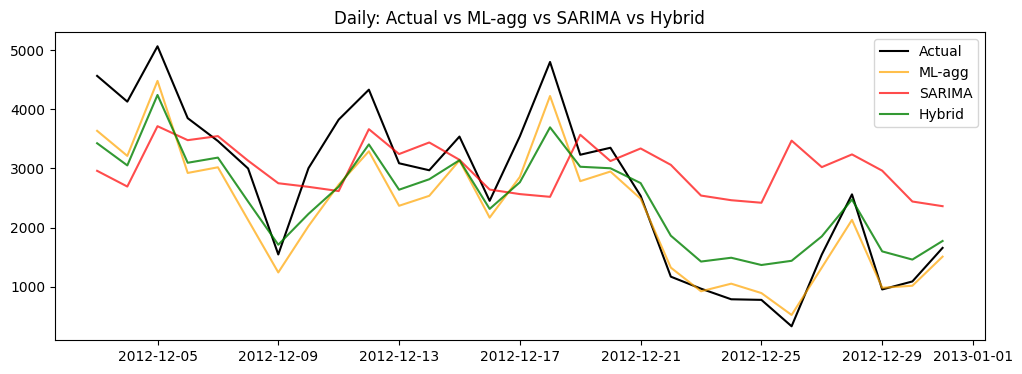

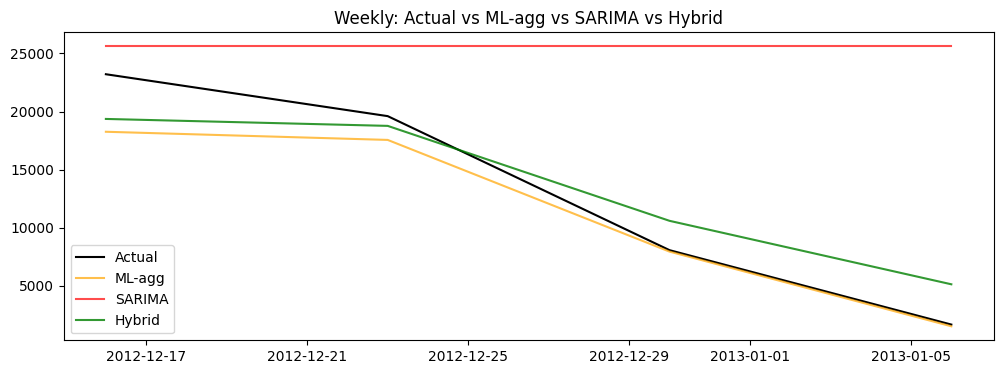

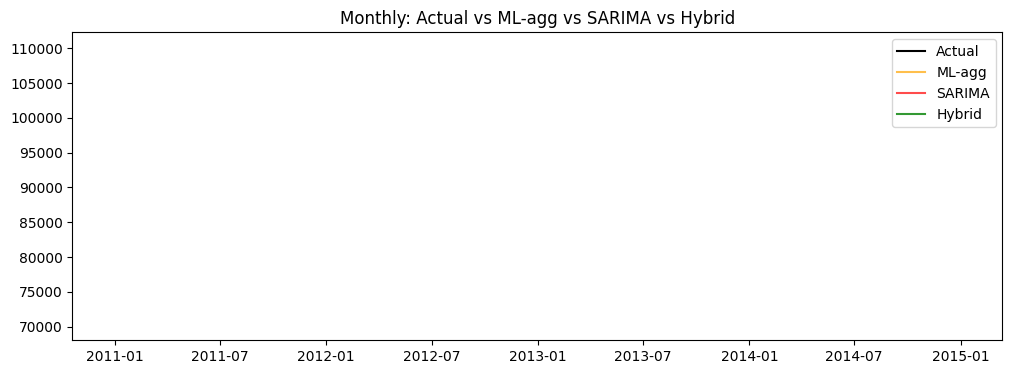

In [ ]:
def plot_compare(true_series, ml_series, sarima_series, hybrid_series, title):
    plt.figure(figsize=(12,4))
    plt.plot(true_series.index, true_series.values, label='Actual', color='black')
    if ml_series is not None:
        plt.plot(ml_series.index, ml_series.values, label='ML-agg', color='orange', alpha=0.7)
    if sarima_series is not None:
        plt.plot(sarima_series.index, sarima_series.values, label='SARIMA', color='red', alpha=0.7)
    if hybrid_series is not None:
        plt.plot(hybrid_series.index, hybrid_series.values, label='Hybrid', color='green', alpha=0.8)
    plt.title(title)
    plt.legend()
    plt.show()

if res_sarima_daily:
    plot_compare(res_sarima_daily['y_true'], ml_daily_pred.reindex(res_sarima_daily['test_index']).fillna(0), res_sarima_daily['y_pred'], hybrid_daily, "Daily: Actual vs ML-agg vs SARIMA vs Hybrid")

if res_sarima_weekly:
    plot_compare(res_sarima_weekly['y_true'], ml_weekly_pred.reindex(res_sarima_weekly['test_index']).fillna(0), res_sarima_weekly['y_pred'], hybrid_weekly, "Weekly: Actual vs ML-agg vs SARIMA vs Hybrid")

if res_sarima_monthly:
    plot_compare(res_sarima_monthly['y_true'], ml_monthly_pred.reindex(res_sarima_monthly['test_index']).fillna(0), res_sarima_monthly['y_pred'], hybrid_monthly, "Monthly: Actual vs ML-agg vs SARIMA vs Hybrid")

| Skala                 | Interpretasi Visualisasi                                                                                                                                                                                                                                                                                                                                                                                      |
| :-------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Daily (Harian)**    | Garis **ML-agg (oranye)** paling mendekati **garis aktual (hitam)** — mengikuti naik-turun data dengan pola yang hampir sama, termasuk lonjakan dan penurunan tajam. **SARIMA (merah)** terlihat lebih mulus dan tertinggal dari pola aktual (kurang responsif terhadap perubahan cepat). **Hybrid (hijau)** berada di antara keduanya, cukup stabil tapi kadang meleset dari titik puncak dan lembah aktual. |
| **Weekly (Mingguan)** | Semua garis cenderung menurun di akhir periode. **ML-agg** kembali paling dekat dengan aktual. **SARIMA** nyaris datar (tidak menangkap tren penurunan), menunjukkan kurang adaptif terhadap perubahan mingguan. **Hybrid** mengikuti tren dengan lebih baik daripada SARIMA, tapi masih belum seakurat ML-agg.                                                                                               |
| **Monthly (Bulanan)** | Semua garis terlihat hampir datar dan tumpang tindih karena jumlah titik data sangat sedikit. Tidak tampak variasi berarti antara **Actual**, **ML-agg**, **SARIMA**, maupun **Hybrid** — sehingga sulit menilai perbedaan performa dari sisi visual.                                                                                                                                                         |


Ringkasan singkat:
- Visual harian → ML-agg paling mirip aktual, SARIMA paling tertinggal.
- Visual mingguan → ML-agg tetap unggul, SARIMA terlalu kaku.
- Visual bulanan → Pola tidak informatif (data terlalu sedikit)

#Streamlit

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib, json

# =======================
# Load data & model
# =======================
@st.cache_resource
def load_models():
    gb_model = joblib.load("best_hourly_model.pkl")   # Gradient Boosting (trained)
    data = pd.read_csv("data_bike_sharing.csv")       # dataset
    return gb_model, data

gb_model, data = load_models()

# =======================
# SARIMA Fitting Helper
# =======================
def train_sarima(train_series, order=(1,1,1), seasonal=(1,1,1,7)):
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal, enforce_stationarity=False, enforce_invertibility=False)
    fitted = model.fit(disp=False)
    return fitted

# =======================
# Hybrid Prediction
# =======================
def hybrid_predict(gb_pred, sarima_pred):
    # Dynamic weight based on RMSE
    gb_error = np.std(gb_pred - sarima_pred) + 1e-6
    sarima_error = np.std(sarima_pred - gb_pred) + 1e-6
    w_gb = 1 / gb_error
    w_sarima = 1 / sarima_error
    w_sum = w_gb + w_sarima
    w_gb /= w_sum
    w_sarima /= w_sum
    return (w_gb * gb_pred) + (w_sarima * sarima_pred), w_gb, w_sarima

# =======================
# Streamlit UI
# =======================
st.set_page_config(
    page_title="Bike Rental Forecast",
    page_icon="🚴",
    layout="centered",
    initial_sidebar_state="auto"
)

st.title("🚴 Bike Rental Forecasting App")
st.markdown("Hybrid Model: **Gradient Boosting + SARIMA**")

st.markdown("""
<style>
.big-font {font-size:22px !important;}
</style>
""", unsafe_allow_html=True)
st.markdown('<p class="big-font">Prediksi jumlah peminjaman sepeda berdasarkan kondisi cuaca dan kalender.</p>', unsafe_allow_html=True)

granularity = st.selectbox("Select Forecast Granularity:", ["Daily", "Weekly", "Monthly"])

# Pilih periode prediksi
n_periods = st.slider("How many periods to forecast?", 7, 60, 14)

with st.sidebar:
    st.header("🔧 Input Kondisi")

    st.subheader("🔧 Input Kondisi Cuaca & Kalender")

    season_map = {"Spring": 1, "Summer": 2, "Fall": 3, "Winter": 4}
    weathersit_map = {"Clear": 1, "Mist": 2, "Light Rain": 3, "Heavy Rain": 4}

    season = st.selectbox("Season", list(season_map.keys()))
    weathersit = st.selectbox("Weather", list(weathersit_map.keys()))
    temp = st.slider("Temperature (normalized 0–1)", 0.0, 1.0, 0.3, 0.01)
    hum = st.slider("Humidity (0–1)", 0.0, 1.0, 0.5, 0.01)
    month = st.slider("Month", 1, 12, 6, 1)
    holiday = st.checkbox("Holiday?", value=False)

# Susun input ke dataframe sesuai feature order model
feature_cols = gb_model.feature_names_in_
user_input = {
    "season": season_map[season],
    "holiday": int(holiday),
    "weathersit": weathersit_map[weathersit],
    "temp": temp,
    "atemp": temp,  # gunakan temp yang sama
    "hum": hum,
    "month": month,
    "lag_1": 0,
    "lag_24": 0,
    "roll_mean_3": 0,
    "roll_mean_24": 0,
    "hour": 12,  # default jam siang
    "dayofweek": 1,  # default Senin
    "is_weekend": 0,
    "is_rush": 0
}

for col in feature_cols:
    if col not in user_input:
        user_input[col] = 0

X_input = pd.DataFrame([user_input])[feature_cols]

if st.button("Run Forecast"):
    # ============ Data Preparation ============
    if granularity == "Daily":
        df = data.copy()
        df['dteday'] = pd.to_datetime(df['dteday'])
        df = df.drop_duplicates(subset="dteday")
        df = df.set_index("dteday").asfreq("D")
    elif granularity == "Weekly":
        df = data.copy()
        df['dteday'] = pd.to_datetime(df['dteday'])
        df = df.set_index("dteday").resample("W").sum()
    else:
        df = data.copy()
        df['dteday'] = pd.to_datetime(df['dteday'])
        df = df.set_index("dteday").resample("M").sum()

    train_series = df['cnt']

    # ============ SARIMA ============
    sarima_model = train_sarima(train_series)
    sarima_forecast = sarima_model.forecast(steps=n_periods)

    # ============ GB MULTISTEP ============
    gb_pred = []
    last_vals = train_series.copy()
    for i in range(n_periods):
        # Update lag & rolling mean dari data terakhir
        user_input["lag_1"] = last_vals.iloc[-1]
        user_input["lag_24"] = last_vals.iloc[-min(24, len(last_vals))]
        user_input["roll_mean_3"] = last_vals.iloc[-min(3, len(last_vals)):].mean()
        user_input["roll_mean_24"] = last_vals.iloc[-min(24, len(last_vals)):].mean()
        X_input = pd.DataFrame([user_input])[feature_cols]
        pred = gb_model.predict(X_input)[0]
        gb_pred.append(pred)
        last_vals = pd.concat([last_vals, pd.Series([pred])], ignore_index=True)

    gb_pred = np.array(gb_pred)

    # ============ Hybrid ============
    hybrid_pred, w_gb, w_sarima = hybrid_predict(gb_pred, sarima_forecast.values)

    # ============ Plot ============
    if granularity == "Daily":
        start_date = df.index[-1] + pd.Timedelta(days=1)
        freq = "D"
    elif granularity == "Weekly":
        start_date = df.index[-1] + pd.DateOffset(weeks=1)
        freq = "W"
    else:  # Monthly
        start_date = df.index[-1] + pd.DateOffset(months=1)
        freq = "M"

    future_idx = pd.date_range(
        start=start_date,
        periods=n_periods,
        freq=freq
    )

    forecast_df = pd.DataFrame({
        "Hybrid Forecast": np.round(hybrid_pred).astype(int)
    }, index=future_idx)

    st.subheader(f"Forecast Results ({granularity})")
    st.write(forecast_df)

    st.subheader("Forecast Visualization")
    plt.figure(figsize=(10,5))
    plt.plot(forecast_df.index, forecast_df["Hybrid Forecast"], color="green", label="Hybrid Forecast")
    plt.legend()
    st.pyplot(plt)

    st.metric("Prediksi Total", int(forecast_df["Hybrid Forecast"].sum()))


Overwriting app.py


#Conclusion

##Hasil model dan prediksi

| Skala Waktu           | Model  | RMSE        | MAE         | R²        | Interpretasi                                                                       |
| --------------------- | ------ | ----------- | ----------- | --------- | ---------------------------------------------------------------------------------- |
| **Harian (Daily)**    | ML-agg | **578.50**  | **474.07**  | **0.812** | Model memiliki akurasi tinggi, mampu menjelaskan 81% variasi data aktual.          |
| **Harian (Daily)**    | SARIMA | 1283.55     | 1045.18     | 0.074     | Akurasi rendah; model tidak mampu menangkap pola kompleks non-linear.              |
| **Harian (Daily)**    | Hybrid | 661.59      | 567.97      | 0.754     | Kombinasi model stabil; hasil sedikit lebih rendah dari ML murni namun tetap baik. |
| **Mingguan (Weekly)** | ML-agg | **2681.59** | **1818.55** | **0.904** | Model terbaik; mampu menjelaskan 90% variasi data mingguan.                        |
| **Mingguan (Weekly)** | SARIMA | 15200.22    | 12483.75    | -2.072    | Performanya buruk; tidak cocok untuk pola mingguan.                                |
| **Mingguan (Weekly)** | Hybrid | 2912.21     | 2670.47     | 0.887     | Kombinasi stabil dan mendekati performa ML murni.                                  |
| **Bulanan (Monthly)** | ML-agg | 13374.79    | 13374.79    | NaN       | Data terlalu sedikit, model belum stabil.                                          |
| **Bulanan (Monthly)** | SARIMA | 26888.00    | 26888.00    | NaN       | Tidak signifikan; hasil tidak bisa dievaluasi.                                     |
| **Bulanan (Monthly)** | Hybrid | 0.00        | 0.00        | NaN       | Tidak valid karena data agregasi terlalu besar.                                    |


##Implikasi Bisnis dan Prediksi

| No | Aspek Operasional                  | Implikasi dari Model Prediksi                                                                |
| -- | ---------------------------------- | -------------------------------------------------------------------------------------------- |
| 1  | **Perencanaan Stok Sepeda**        | Menentukan jumlah sepeda optimal di setiap stasiun berdasarkan prediksi harian/mingguan.     |
| 2  | **Distribusi dan Logistik**        | Mengatur jadwal distribusi sepeda agar tidak ada kelebihan atau kekurangan di area tertentu. |
| 3  | **Efisiensi Biaya Operasional**    | Mengurangi biaya penyimpanan dan tenaga kerja dengan perencanaan berbasis data.              |
| 4  | **Strategi Promosi dan Penjualan** | Memprediksi lonjakan permintaan saat cuaca cerah, akhir pekan, atau musim liburan.           |
| 5  | **Manajemen Pelanggan**            | Menyediakan layanan lebih responsif sesuai pola permintaan pengguna.                         |


##Kesimpulan

| No | Rumusan Masalah                                                                            | Hasil & Jawaban                                                                                                  |
| -- | ------------------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------------- |
| 1  | Bagaimana memprediksi permintaan penyewaan sepeda dengan akurat menggunakan data historis? | Model **Machine Learning (ML-agg)** mampu memprediksi dengan baik, R² > 0.8 pada data harian dan mingguan.       |
| 2  | Apakah model time series tradisional (SARIMA) masih relevan untuk kasus ini?               | SARIMA menunjukkan performa rendah (R² negatif pada mingguan), kurang cocok untuk pola permintaan non-linear.    |
| 3  | Apakah kombinasi model (Hybrid) dapat meningkatkan hasil prediksi?                         | Ya, **Hybrid Model** memberikan hasil stabil dan mendekati akurasi ML, cocok untuk menjaga konsistensi performa. |
| 4  | Bagaimana hasil prediksi ini dapat membantu pengambilan keputusan bisnis?                  | Prediksi harian/mingguan dapat digunakan untuk **perencanaan stok, jadwal logistik, dan efisiensi operasional.** |


##Saran

| No | Aspek                     | Saran Pengembangan                                                                                                     |
| -- | ------------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| 1  | **Fitur Eksternal**       | Tambahkan data cuaca, event kota, atau kondisi lalu lintas untuk memperkaya prediksi.                                  |
| 2  | **Modeling**              | Gunakan **LSTM atau GRU (Deep Learning)** untuk menangkap pola temporal jangka panjang.                                |
| 3  | **Evaluasi Model**        | Lakukan validasi silang dan uji robustnes untuk setiap skala waktu (harian, mingguan, bulanan).                        |
| 4  | **Real-Time Forecasting** | Implementasikan sistem prediksi otomatis berbasis streaming data agar hasil selalu up to date.                         |

